# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob

In [2]:
import os
from dataclasses import dataclass
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf


def get_basename_no_ext(inp):
    return os.path.splitext(os.path.basename(inp[0]))[0]


def get_basenames_no_ext_arr(arr):
    arr_base = np.array(arr).reshape(-1,1)
    arr_base = [os.path.splitext(os.path.basename(inp[0]))[0] for inp in arr_base]
#     arr_base = np.apply_along_axis(get_basename_no_ext, 1, arr_base)
    return arr_base


def check_existance(img_name, true_labels_paths):
    true_labels_paths_base = get_basenames_no_ext_arr(true_labels_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    if img_name_no_ext in true_labels_paths_base:
        return 1
    else:
        return 0


@dataclass
class Data:
    image: str
    label: str
    mask: str=""


def get_df(images_path, labels_path):
    img_paths = glob(os.path.join(images_path, "*"))
    label_paths = glob(os.path.join(labels_path, "*"))

    rows = []
    for i, img_path in enumerate(img_paths):
        img_class = check_existance(img_path, label_paths)
        rows.append([img_path, img_class, 0])
    return np.array(rows)

def get_df_acc(images_path, labels_path, masks_path):
    img_paths = glob(os.path.join(images_path, "*"))
    mask_paths = [os.path.join(masks_path, f"mask{os.path.splitext(os.path.basename(img_path))[0][3:]}.jpg") for img_path in img_paths]
    zeros = np.ones(len(img_paths))
    rows = np.concatenate((np.array(img_paths).reshape(-1, 1), zeros.reshape(-1, 1),
                           np.array(mask_paths).reshape(-1, 1)), axis=1)
    return rows

def append_images(img_path, req_size):
    img_paths = glob(os.path.join(img_path, "*"))
    dir_size = len(img_paths)
    print(dir_size)
    if dir_size < req_size:
        print("len is less than req_size, appending...")
        for i in range(req_size // dir_size + 1):
            img_paths = img_paths + img_paths
        img_paths = img_paths[:req_size]
    else:
        img_paths = img_paths[:req_size]
    zeros = np.zeros(req_size)
    rows = np.concatenate((np.array(img_paths).reshape(-1, 1), zeros.reshape(-1, 1),
                           zeros.reshape(-1, 1)), axis=1)
    return rows

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-02-18 02:09:21.013762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 02:09:22.887067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:22.927981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:22.929363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

True

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:23.653536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:23.654805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13598 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [4]:
train_data = Data("/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/images/train",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/labels/train",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/masks/train")
rows_label_1 = get_df_acc(train_data.image, train_data.label, train_data.mask)
img_path_label_0 = "/home/ubuntu/workspace/datasets/architecture_and_3d-printers_bw"
rows_label_0 = append_images(img_path_label_0, rows_label_1.shape[0])
rows = np.concatenate((rows_label_0, rows_label_1))
df_train = pd.DataFrame(rows_label_1, columns=['filename', 'label', 'mask_'])
df_train.label = df_train.label.astype("float").astype("int8")
# print(df_train.info())
# print(len(df_train[df_train.label == 0]))
# print(len(df_train[df_train.label == 1]))

val_data = Data("/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/images/val",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/labels/val",
                "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/masks/val")
rows_label_1 = get_df_acc(val_data.image, val_data.label, val_data.mask)
img_path_label_0 = "/home/ubuntu/workspace/datasets/architecture_and_3d-printers_bw"
rows_label_0 = append_images(img_path_label_0, rows_label_1.shape[0])
rows = np.concatenate((rows_label_0, rows_label_1))
df_val = pd.DataFrame(rows_label_1, columns=['filename', 'label', 'mask_'])
df_val.label = df_val.label.astype("float").astype("int8")

test_data = Data("/home/ubuntu/workspace/create_train_set/data/rgb_images_spag_&_bckg",
                "/home/ubuntu/workspace/create_train_set/data/yolo-labels/")
rows = get_df(test_data.image, test_data.label)
df_test = pd.DataFrame(rows, columns=['filename', 'label', 'mask_'])
df_test.label = df_val.label.astype("float").astype("int8")

7293
7293


## Prepare paths of input images and target segmentation masks

In [5]:
tf.config.list_physical_devices('GPU')
tf.__version__
import sys
sys.version

2022-02-18 02:09:23.874723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:23.876190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:23.877478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]'

In [6]:
import os

img_size = (160, 160)
num_classes = 2
batch_size = 32

input_img_paths = df_train.filename.to_list()
target_img_paths = df_train.mask_.astype(str).to_list()

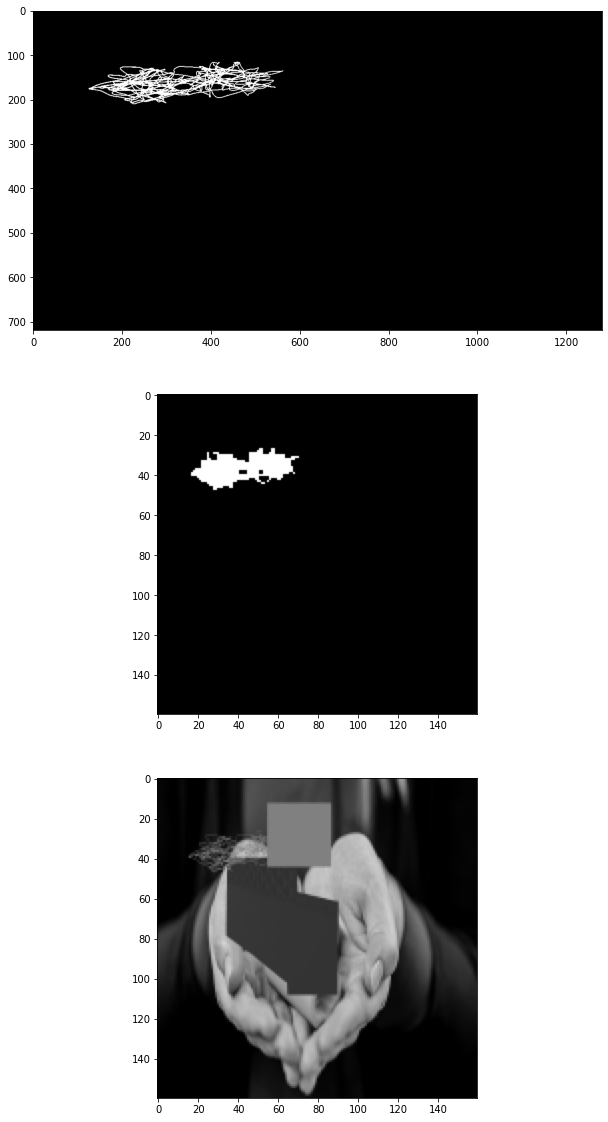

In [7]:
# process mask
def resize_mask(mask, target_shape):
    kernel = np.ones((10, 10), np.uint8)
    mask =  cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    shape = (target_shape[1], target_shape[0])
    mask = cv.resize(mask, shape, interpolation=cv.INTER_NEAREST) #cv.INTER_AREA
    return mask

def img_to_binary(mask):
    mask[mask<=125] = 0
    mask[mask>125] = 1
    return mask

def load_img_cv(path, target_size, is_mask=False):
    if not is_mask:
        img = cv.imread(path)
        shape = (target_size[1], target_size[0])
        img = cv.resize(img, shape, interpolation=cv.INTER_AREA) 
    else:
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        img = resize_mask(img, target_size)
        img = img_to_binary(img)
    return img

mask = cv.imread(target_img_paths[9], cv.IMREAD_GRAYSCALE)
target_size = (160,160)
# print(mask.shape)
# kernel = np.ones((10, 10), np.uint8)
# mask =  cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
# img = cv.erode(img, kernel, iterations=1)
# img = cv.dilate(img, kernel, iterations=1)
mask_new = load_img_cv(target_img_paths[9], target_size, is_mask=True)
img = load_img_cv(input_img_paths[9], target_size, is_mask=False)
fig, ax = plt.subplots(3,1,figsize=(25,20))
ax[0].imshow(mask, cmap="gray")
ax[1].imshow(mask_new, cmap="gray")
ax[2].imshow(img, cmap="gray")

## What does one input image and corresponding segmentation mask look like?

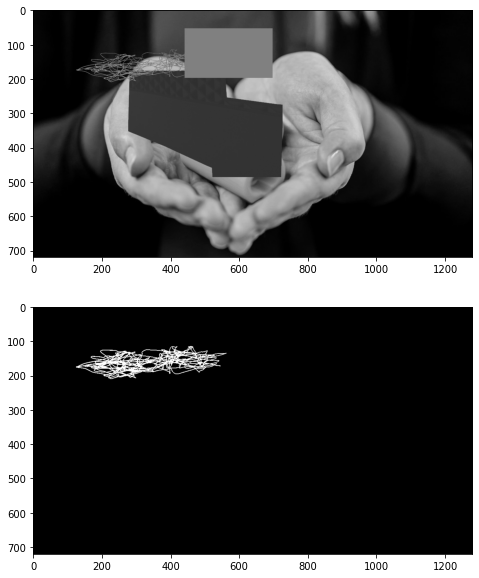

In [8]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import numpy as np

# # Display input image #7
# display(Image(filename=input_img_paths[9]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
# display(img)

img = cv.imread(input_img_paths[9])
mask = cv.imread(target_img_paths[9])
mask = (mask - np.amin(mask)) / np.amax(mask - np.amin(mask))
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].imshow(img)
ax[1].imshow(mask)

## Prepare `Sequence` class to load & vectorize batches of data

In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

    
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img_cv(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img_cv(path, target_size=self.img_size, is_mask=True)
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
        return x, y


## Prepare U-Net Xception-style model

In [10]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

2022-02-18 02:09:41.641485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:41.643107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:41.644387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:41.645728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 02:09:41.647055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Set aside a validation split

In [12]:
import random

# Split our img paths into a training and a validation set
# val_samples = 1000
# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = df_train.filename.to_list()
train_target_img_paths = df_train.mask_.astype(str).to_list()
val_input_img_paths = df_val.filename.to_list()
val_target_img_paths = df_val.mask_.astype(str).to_list()

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentationd.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


2022-02-18 02:10:10.161251: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


227/227 [==============================] - 189s 781ms/step - loss: 0.3624 - val_loss: 0.2798
Epoch 2/15
227/227 [==============================] - 159s 698ms/step - loss: 0.1608 - val_loss: 0.1835
Epoch 3/15
227/227 [==============================] - 158s 697ms/step - loss: 0.1387 - val_loss: 0.1667
Epoch 4/15
 71/227 [========>.....................] - ETA: 1:27 - loss: 0.1307

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.